<a href="https://colab.research.google.com/github/BarAvni/deep_learning_2020/blob/master/Homework_3_shortest_path_Bar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dgl
import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from torch.utils.data import Dataset, DataLoader
import glob
import json
from tqdm.notebook import tqdm
import torch.optim as optim
import numpy as np
import networkx as nx
import time

import matplotlib.pyplot as plt

     |████████████████████████████████| 3.0MB 4.6MB/s 


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [2]:
!wget https://www.dropbox.com/sh/rl0uf65qyyrwx86/AAAQKpWUsOqX-EkXT-9R533va?dl=0
!unzip -qq AAAQKpWUsOqX-EkXT-9R533va?dl=0
!unzip -qq training_data.zip
!unzip -qq test_data.zip
path_to_ds = 'training_data/'
path_to_test_ds = 'test_data/'

--2020-06-21 20:01:49--  https://www.dropbox.com/sh/rl0uf65qyyrwx86/AAAQKpWUsOqX-EkXT-9R533va?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/rl0uf65qyyrwx86/AAAQKpWUsOqX-EkXT-9R533va [following]
--2020-06-21 20:01:49--  https://www.dropbox.com/sh/raw/rl0uf65qyyrwx86/AAAQKpWUsOqX-EkXT-9R533va
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc00e9b0ba7f0f7bcac5e388d5f9.dl.dropboxusercontent.com/zip_download_get/Adc95VUoMrdKffEQNi9C8UvOwrpFqggZzUVF3x82J3piKQIjxuzZiUMc2biXsfEr17xJFtAApldrd1nZYOGszSIHIbCh2zlZO8Ke3mFl6I-2Lg [following]
--2020-06-21 20:01:50--  https://uc00e9b0ba7f0f7bcac5e388d5f9.dl.dropboxusercontent.com/zip_download_get/Adc95VUoMrdKffEQNi9C8UvOwrpFqggZzUVF3x82J3piKQIjxuzZiUMc2biXsfEr17xJFtAApldrd1nZYOGs

In [3]:
class CustomDataset(Dataset):
    
    def __init__(self, path):
        filelist = glob.glob(path+'/*.json')
        self.graphs = []
        for fname in tqdm(filelist):
            with open(fname) as jfile:
                graph = nx.node_link_graph(json.load(jfile))
                g = dgl.DGLGraph()
                g.from_networkx(graph,node_attrs=['node_features'],edge_attrs=['distance','on_path'])        
                self.graphs.append(g)
        
    def __len__(self):      
        return len(self.graphs)

    def __getitem__(self, idx):    
        return self.graphs[idx], self.graphs[idx].edata['on_path']

In [4]:
train_ds = CustomDataset(path_to_ds)
test_ds = CustomDataset(path_to_test_ds)

In [5]:
train_ds[495]

(DGLGraph(num_nodes=47, num_edges=188,
          ndata_schemes={'node_features': Scheme(shape=(2,), dtype=torch.float32)}
          edata_schemes={'distance': Scheme(shape=(), dtype=torch.float32), 'on_path': Scheme(shape=(), dtype=torch.int64)}),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

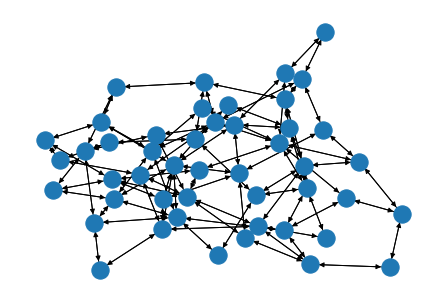

In [6]:
nx.draw( dgl.to_networkx(train_ds[495][0]) )

In [7]:
def collate(samples):
    # The input `samples` is a list, a batch of whatever comes out of your dataset object   
    graphs = [x[0] for x in samples]
    labels = [x[1] for x in samples]
    batched_graph = dgl.batch(graphs,node_attrs=['node_features'],edge_attrs=['distance'])
    targets = torch.cat(labels)    
    return batched_graph, targets.unsqueeze(1).float()

In [14]:
node_hidden1 = 20
edge_hidden1 = 20
# node_out = 10

In [15]:
import torch.nn as nn
import torch.nn.functional as F


#this function is the edge update function - 

class EdgeNetwork(nn.Module):
    def __init__(self):
        super(EdgeNetwork, self).__init__()
        in_features = 2*(2+node_hidden1)+1
        print('EdgeNetwork: ', in_features)
        self.Sequent = nn.Sequential(
            nn.Linear(in_features,edge_hidden1),
            nn.ReLU(),
            nn.Linear(edge_hidden1,edge_hidden1),
            nn.ReLU()
        )
        
    def forward(self, x):
        
        #your input x is an object with the following properties:
        #x.dst['node_features'], x.dst['node_hidden_state']
        #x.src['node_features'], x.src['node_hidden_state']
        #x.data['distance']
        
        #put them together with torch.cat
        
        #use a neural network to create an edge hidden represetation - 
        
        #you return a dictionary with what you want to "send" to the reciving node
        
#         print("dst: ", x.dst['node_features'].shape)
#         print("dst_h: ", x.dst['node_hidden_state'].shape)
#         print("src: ", x.src['node_features'].shape)
#         print("src_h: ", x.src['node_hidden_state'].shape)
#         print("distance: ", torch.unsqueeze(x.data['distance'],1).shape)        
        x_cat = torch.cat((x.dst['node_features'], 
                  x.dst['node_hidden_state'], 
                  x.src['node_features'], 
                  x.src['node_hidden_state'],
                  torch.unsqueeze(x.data['distance'],1)), 1)
#         print("here3: ", x_cat.shape)
        output = self.Sequent(x_cat)
#         print("here4 - output: ", output.shape)
        return {'edge hidden represetation': output }

    
class NodeNetwork(nn.Module):
    def __init__(self):
        super(NodeNetwork, self).__init__()
        in_features = 2+edge_hidden1+node_hidden1
        print('NodeNetwork: ', in_features)
        self.Sequent = nn.Sequential(
            nn.Linear(in_features,node_hidden1),
            nn.LeakyReLU(),
            nn.Linear(node_hidden1,node_hidden1),
            nn.LeakyReLU()
        )
        
    def forward(self, x):
        #this time your input x has:
        # x.mailbox['edge hidden represetation'] -> this is what you send with the edge update function above - 
        # it will have the size of the node neighborhood - 
        # (Batch size, number of nodes in neighborhood, edge hidden rep size), so you need to sum/mean over dim=1 
        # x.data['node_hidden_state'] and x.data['node_features'] (this is the existing state of your node)
        # you need to torch.cat the message sum, node hidden state, and node features 
        #- and then apply some fully connected neural network

#         print("malibox: ", x.mailbox['edge hidden represetation'].sum(1).shape)
#         print("data: ", x.data['node_features'].shape)
#         print("data_h: ", x.data['node_hidden_state'].shape)
 
        x_cat = torch.cat((
            x.mailbox['edge hidden represetation'].sum(1),
            x.data['node_features'],
            x.data['node_hidden_state']
        ), 1)
        
#         print("here1: ", x_cat.shape)
        # return a new hidden state for the node
        out = self.Sequent(x_cat)
#         print("here2 - out: ", out.shape)
        return {'node_hidden_state': out }


class EdgeClassifier(nn.Module):
    def __init__(self):
        super(EdgeClassifier, self).__init__()
        in_features = 2*(2+node_hidden1)+1
        print('EdgeClassifier: ', in_features)
        self.layer1 = nn.Sequential(
            nn.Linear(in_features,1),
            nn.Sigmoid()
        )
       
    def forward(self, x):

#         print("dst: ", x.dst['node_features'].shape)
#         print("dst_h: ", x.dst['node_hidden_state'].shape)
#         print("src: ", x.src['node_features'].shape)
#         print("src_h: ", x.src['node_hidden_state'].shape)
#         print("distance: ", torch.unsqueeze(x.data['distance'],1).shape)        
        
        x_cat = torch.cat((x.dst['node_features'], 
                  x.dst['node_hidden_state'], 
                  x.src['node_features'], 
                  x.src['node_hidden_state'],
                  torch.unsqueeze(x.data['distance'],1)), 1)
#         print(x_cat.shape)
        out = self.layer1(x_cat)#torch.round(self.layer1(x_cat))
        return {'edge_class_prediction': out }


class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        # you need to create a network that 
        # will initialize your node hidden state based only on the node features -
        self.node_init = nn.Sequential(
            nn.Linear(2,node_hidden1),
            nn.ReLU(),
        )
        
        self.edge_network = EdgeNetwork()
        self.node_network = NodeNetwork()
        
        #this edge classifier is also an edge update function - 
        #but it needs to return something of size 1 (the edge class prediction)
        #so either create a different model for this, or make the EdgeNetwork configurable
        self.edge_classifier = EdgeClassifier()
        
    def forward(self, g):
        
        g.ndata['node_hidden_state'] = self.node_init(g.ndata['node_features'])
        
        for i in range(12):
#             print(i, ": ", g.ndata['node_hidden_state'].shape)
            g.update_all(self.edge_network,self.node_network)
            
        #we want to classify the edges - so finally apply your edge classifier -
#         print("here")
        g.apply_edges(self.edge_classifier)
        
        #and extract its output 
        out = g.edata['edge_class_prediction']

        
        return out

In [16]:
net = Classifier()
net = net.to(torch.device('cuda'))
data_loader = DataLoader(train_ds, batch_size=30, shuffle=True, collate_fn=collate)
test_data_loader = DataLoader(test_ds, batch_size=30, shuffle=True, collate_fn=collate)
# optimizer = optim.Adam(net.parameters(), lr=1e-2)
# optimizer = optim.Adam(net.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0,amsgrad=False)
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)
loss_func = nn.BCEWithLogitsLoss(pos_weight=20*torch.ones(1).to(torch.device('cuda')))

EdgeNetwork:  45
NodeNetwork:  42
EdgeClassifier:  45


In [ ]:
# epoch_losses, epoch_val_losses = [], []

for epoch in range(12):
    t0 = time.time()

    net.train()
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    total_positives = 0
    total_negatives = 0
    epoch_loss = 0
    for x,y in data_loader:
        x = x.to(torch.device('cuda'))
        y = y.cuda()
        predicted = net(x)
#         batch_false_positive = (predicted!=y) & (y==0) )[0])
#         batch_false_negative = len(np.where( (predicted_values!=y_values) & (y_values==1) )[0])
        batch_loss = loss_func(predicted, y) #+ weighted_false_positive +  weighted_false_negative
        epoch_loss += batch_loss.detach().item()

        optimizer.zero_grad()
        with torch.autograd.set_detect_anomaly(True):
            batch_loss.backward(retain_graph=True)
        optimizer.step()
        
        y_values = y.cpu().data.numpy()
        predicted_values = torch.round(predicted.cpu()).data.numpy()
        total_positives+=len(np.where( y_values==1 )[0])
        total_negatives+=len(np.where( y_values==0 )[0])
        true_positive+= len(np.where( (predicted_values==y_values) & (y_values==1) )[0])
        true_negative+= len(np.where( (predicted_values==y_values) & (y_values==0) )[0])
        false_positive+= len(np.where( (predicted_values!=y_values) & (y_values==0) )[0])
        false_negative+= len(np.where( (predicted_values!=y_values) & (y_values==1) )[0])

#     sample_data = predicted.cpu().data.numpy()
#     sample_y = y.cpu().data.numpy()

    TP = true_positive/total_positives
    FN = false_negative/total_positives
    TN = true_negative/total_negatives
    FP = false_positive/total_negatives
    print("Epoch ", epoch)
    sample_data = torch.cat((predicted,y),1)
    print(sample_data)
    print("   Training:   loss: {:.6f}  |  TP: {:.6f} | TN: {:.6f} | FP: {:.6f} | FN: {:.6f}".format(
                epoch_loss, TP, TN, FP, FN))
#     print("               TP: ", true_positive, false_negative)
    
    net.eval()
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    total_positives = 0
    total_negatives = 0
    epoch_val_loss = 0
    for x,y in test_data_loader:
        x = x.to(torch.device('cuda'))
        y = y.cuda()
        predicted = net(x)
        batch_val_loss = loss_func(predicted, y)
        epoch_val_loss += batch_loss.detach().item()
        y_values = y.cpu().data.numpy()
        predicted_values = torch.round(predicted.cpu()).data.numpy()
        total_positives+=len(np.where( y_values==1 )[0])
        total_negatives+=len(np.where( y_values==0 )[0])
        true_positive+= len(np.where( (predicted_values==y_values) & (y_values==1) )[0])
        true_negative+= len(np.where( (predicted_values==y_values) & (y_values==0) )[0])
        false_positive+= len(np.where( (predicted_values!=y_values) & (y_values==0) )[0])
        false_negative+= len(np.where( (predicted_values!=y_values) & (y_values==1) )[0])
    TP = true_positive/total_positives
    FN = false_negative/total_positives
    TN = true_negative/total_negatives
    FP = false_positive/total_negatives
    print("   Validation: loss: {:.6f}  |  TP: {:.6f} | TN: {:.6f} | FP: {:.6f} | FN: {:.6f}".format(
                epoch_val_loss, TP, TN, FP, FN))


Epoch  0
tensor([[0.4526, 1.0000],
        [0.3151, 0.0000],
        [0.1692, 0.0000],
        ...,
        [0.3475, 0.0000],
        [0.3020, 0.0000],
        [0.3732, 0.0000]], device='cuda:0', grad_fn=<CatBackward>)
   Training:   loss: 496.914072  |  TP: 0.064242 | TN: 0.992208 | FP: 0.007792 | FN: 0.935758
   Validation: loss: 484.246464  |  TP: 0.286869 | TN: 0.948315 | FP: 0.051685 | FN: 0.713131
Epoch  1
tensor([[0.7733, 0.0000],
        [0.6192, 0.0000],
        [0.7673, 0.0000],
        ...,
        [0.3422, 0.0000],
        [0.6393, 0.0000],
        [0.4895, 0.0000]], device='cuda:0', grad_fn=<CatBackward>)
   Training:   loss: 480.619523  |  TP: 0.525855 | TN: 0.832888 | FP: 0.167112 | FN: 0.474145
   Validation: loss: 532.986185  |  TP: 0.977813 | TN: 0.240806 | FP: 0.759194 | FN: 0.022187
Epoch  2
tensor([[0.1928, 0.0000],
        [0.2787, 0.0000],
        [0.6734, 0.0000],
        ...,
        [0.6391, 0.0000],
        [0.7071, 0.0000],
        [0.4408, 0.0000]], device=

In [ ]:
# from scipy.special import expit, logit

# fig,ax = plt.subplots(1,2,figsize=(6,3),dpi=150)

# ax[0].set_title('Target')
# ax[1].set_title('Model Prediction')

# net.eval()
# net.cpu()

# dgl_g = test_ds[5578][0]

# output_pred = net(dgl_g).data.numpy()

# nx_graph = dgl.to_networkx(dgl_g)
# pos = {i: dgl_g.ndata['node_features'][i][:2].data.numpy() for i in range(len(dgl_g.ndata['node_features']))} #nx.spring_layout(nx_graph)
# edge_list = [e for i,e in enumerate(nx_graph.edges) if dgl_g.edata['on_path'][i]==1]

# edge_widths = np.array([expit(output_pred[i][0]) for i in range(len(output_pred))])
# predicted_edge_list = [e for i,e in enumerate(nx_graph.edges) if expit(output_pred[i])[0]>=0.5]

# pos = nx.spring_layout(nx_graph)


# nx.draw( nx_graph ,pos=pos ,ax=ax[0] ,node_size=5,arrows=False)
# nx.draw_networkx_edges(nx_graph,pos=pos,edgelist=edge_list,width=2,edge_color='r',ax=ax[0],arrows=False)

# nx.draw( nx_graph ,pos=pos ,ax=ax[1] ,node_size=5,arrows=False)
# nx.draw_networkx_edges(nx_graph,pos=pos,edgelist=predicted_edge_list,width=2,edge_color='r',ax=ax[1],arrows=False)

# plt.show()

In [ ]:
# net.eval()

# true_positive = 0
# false_positive = 0
# true_negative = 0
# false_negative = 0
# total_positives = 0
# total_negatives = 0

# for i, (x,y) in enumerate(test_data_loader):
        
#         y = y.data.numpy()

#         prediction = net(x).cpu().data.numpy()
        
#         prediction[prediction >= 0.5] = 1
#         prediction[prediction <0.5] = 0
        
#         total_positives+=len(np.where( y==1 )[0])
#         total_negatives+=len(np.where( y==0 )[0])
        
#         true_positive+= len(np.where( (prediction==y) & (y==1) )[0])
#         true_negative+= len(np.where( (prediction==y) & (y==0) )[0])
#         false_positive+= len(np.where( (prediction!=y) & (y==0) )[0])
#         false_negative+= len(np.where( (prediction!=y) & (y==1) )[0])
        
        
# print(true_positive/total_positives)
# print(false_negative/total_positives)
# print(true_negative/total_negatives)
# print(false_positive/total_negatives)

In [ ]:
# import torch as th
# g = dgl.DGLGraph()
# g.add_nodes(3)
# g.add_edges([0, 1], [1, 2])   # 0 -> 1, 1 -> 2
# g.edata['y'] = th.ones(2, 1)
# # Doubles the edge feature.
# def double_feature(edges): return {'y': edges.data['y'] * 2}
# g.apply_edges(func=double_feature, edges=0) # Apply func to the first edge.
# print(g.edata)
# nx.draw( dgl.to_networkx(g) )

In [ ]:
# a = torch.rand(2,3)
# b = torch.rand(2,1)
# c = torch.rand(2,3)

# d = torch.cat((a,b,c), 1)
# d

In [ ]:
# d.max(1)